<a href="https://colab.research.google.com/github/Vibertexs/Tensorflow-Projects/blob/main/EmotionDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run this to download data and prepare our environment!  { display-mode: "form" }

import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import gdown
import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

###Getting the csv data loaded

dataset_url = 'https://drive.google.com/uc?id=1xFiYsULlQWWmi2Ai0fHjtApniP5Pscuf'
dataset_path = './ferdata.csv'
gdown.download(dataset_url, dataset_path, True)

###Getting the Dlib Shape predictor!

dlibshape_url = 'https://drive.google.com/uc?id=17D3D89Gke6i5nKOvmsbPslrGg5rVgOwg'
dlibshape_path ='./shape_predictor_68_face_landmarks.dat'
gdown.download(dlibshape_url, dlibshape_path, True)

###Getting the Xpure loaded

pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path,True)

###Getting the Xdata loaded

dataX_url = 'https://drive.google.com/uc?id=1sIJGxUM6rNBcWxucs6iynDepeKU1Q56p'
dataX_path = './dataX.npy'
gdown.download(dataX_url, dataX_path, True)


###Getting the Ydata loaded

dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)

print ("Data Downloaded!")

'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()

def plot_graphs(history, best):
  
  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#Integer to Label Mapping
label_map = {"0":"ANGRY","1":"HAPPY","2":"SAD","3":"SURPRISE","4":"NEUTRAL"}


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
  
  
  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents 
  #                  the x and y co-ordinates of facial keypoints
  
  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents 
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -4
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest')
  plt.show()
  
"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
"""
  
def landmarks_edist(face_landmarks):
    e_dist = []
    for i in range(len(face_landmarks)):
        for j in range(len(face_landmarks)):
            if i!= j:
                e_dist.append(distance.euclidean(face_landmarks[i],face_landmarks[j]))
    return e_dist
  
def compare_learning(mlp, lm, cnn, vgg): # there's one model missing: MLP from pixels
  
  # summarize history for accuracy
  plt.plot(vgg.history['val_accuracy'],)
  plt.plot(cnn.history['val_accuracy'])
  plt.plot(mlp.history['val_accuracy'],)
  plt.plot(lm.history['val_accuracy'])
  plt.ylabel('validitation accuracy')
  plt.xlabel('epoch')
  plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1,1])
  plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
  plt.show()


Data Downloaded!


In [ ]:
# the number of times we pass all the training data through the model 
epochs = 40
# the number of examples we pass to the model at each time
batch_size = 20
# the proportion of testing data we set aside (e.g. 10%)
test_ratio = .1
# the number of emotion categories we have to predict
n_labels = 5

In [ ]:
import pandas as pd

# load data 
dataX_pixels = np.load('pureX.npy')
dataY_pixels = np.load('dataY.npy')

In [ ]:
# convert labels to one hot encoding
y_onehot = keras.utils.to_categorical(dataY_pixels, len(set(dataY_pixels)))
# what does this data type look like? 

In [ ]:
# split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)

#### Standardize the data ##########
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)

In [ ]:
width, height = 48, 48


In [ ]:
# pixels were vectors
print(X_train.shape) 

(18000, 2304)


In [ ]:
X_train_cnn = X_train.reshape(len(X_train),height,width)
X_test_cnn = X_test.reshape(len(X_test),height,width)

# we've converted them to images
print(X_train_cnn.shape) 

(18000, 48, 48)


In [ ]:
# now we add one more dimension for model compatability
X_train_cnn = np.expand_dims(X_train_cnn,3)
X_test_cnn = np.expand_dims(X_test_cnn,3)

print(X_train_cnn.shape)

(18000, 48, 48, 1)


In [ ]:
############### CALL YOUR MODEL 'cnn_model' 

# Initiate the mode
cnn_model = Sequential()

# this conv layer has 64 filters! the input shape needs to be the same dimensions of the image
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
# max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
# max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatten all the outputs between convolutional and dense layers
cnn_model.add(Flatten())
# add a "dense layer" (i.e. the fully connected layers in MLPs) with dropout
cnn_model.add(Dense(4096, activation='relu'))
cnn_model.add(Dense(4096, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1000, activation='relu'))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(n_labels, activation='softmax'))
#YOUR CODE HERE

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 128)      

In [ ]:
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_cnn_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# compliling the model with adam optimixer and categorical crossentropy loss
cnn_model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

# training the model
cnn_history = cnn_model.fit(X_train_cnn, y_train, batch_size=60, epochs=20, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test_cnn, y_test), shuffle=True)

Epoch 1/20
300/300 [==============================] - 30s 72ms/step - loss: 2.6508 - accuracy: 0.2504 - val_loss: 1.7101 - val_accuracy: 0.2520

Epoch 00001: val_loss improved from inf to 1.71012, saving model to best_cnn_model.h5
Epoch 2/20
300/300 [==============================] - 22s 72ms/step - loss: 1.4359 - accuracy: 0.3753 - val_loss: 1.3888 - val_accuracy: 0.3955

Epoch 00002: val_loss improved from 1.71012 to 1.38879, saving model to best_cnn_model.h5
Epoch 3/20
300/300 [==============================] - 22s 73ms/step - loss: 1.3033 - accuracy: 0.4418 - val_loss: 1.1645 - val_accuracy: 0.5205

Epoch 00003: val_loss improved from 1.38879 to 1.16448, saving model to best_cnn_model.h5
Epoch 4/20
300/300 [==============================] - 22s 74ms/step - loss: 1.1638 - accuracy: 0.5267 - val_loss: 1.1293 - val_accuracy: 0.5435

Epoch 00004: val_loss improved from 1.16448 to 1.12931, saving model to best_cnn_model.h5
Epoch 5/20
300/300 [==============================] - 23s 75ms/s

32/32 [==============================] - 1s 21ms/step - loss: 2.0866 - accuracy: 0.6260


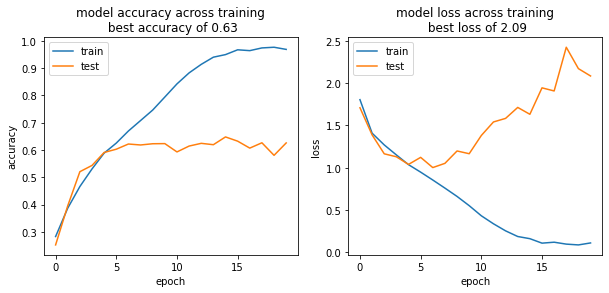

In [ ]:
cnn_performance = cnn_model.evaluate(X_test_cnn, y_test, batch_size=64)
plot_graphs(cnn_history, cnn_performance);


In [ ]:
#@title Run this to build your transfer learning model { display-mode: "form" }

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.applications.vgg16 import VGG16

# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(5, activation = 'sigmoid'))

# finally, we build the vgg model and turn it on so we can use it!
vgg_model.compile(loss = 'categorical_crossentropy', 
          optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
          metrics=['accuracy'])

X_TRAIN = np.array([np.transpose(np.array([X_train_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_train))])
X_TEST = np.array([np.transpose(np.array([X_test_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_test))])

#training the model
vgg_history = vgg_model.fit(X_TRAIN, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpoint],
          validation_data=(X_TEST, y_test),
          shuffle=True)

Epoch 1/40
900/900 [==============================] - 32s 35ms/step - loss: 1.4609 - accuracy: 0.3515 - val_loss: 1.0587 - val_accuracy: 0.5640

Epoch 00001: val_loss did not improve from 1.00137
Epoch 2/40
900/900 [==============================] - 31s 34ms/step - loss: 1.0737 - accuracy: 0.5648 - val_loss: 0.9977 - val_accuracy: 0.5900

Epoch 00002: val_loss improved from 1.00137 to 0.99770, saving model to best_cnn_model.h5
Epoch 3/40
900/900 [==============================] - 31s 34ms/step - loss: 0.9737 - accuracy: 0.6109 - val_loss: 0.9160 - val_accuracy: 0.6270

Epoch 00003: val_loss improved from 0.99770 to 0.91595, saving model to best_cnn_model.h5
Epoch 4/40
900/900 [==============================] - 31s 34ms/step - loss: 0.8690 - accuracy: 0.6616 - val_loss: 0.8687 - val_accuracy: 0.6575

Epoch 00004: val_loss improved from 0.91595 to 0.86870, saving model to best_cnn_model.h5
Epoch 5/40
900/900 [==============================] - 31s 34ms/step - loss: 0.7896 - accuracy: 0.69

In [ ]:
vgg_performance = vgg_model.evaluate(X_TEST, y_test, batch_size=64)

32/32 [==============================] - 1s 21ms/step - loss: 1.9339 - accuracy: 0.7045


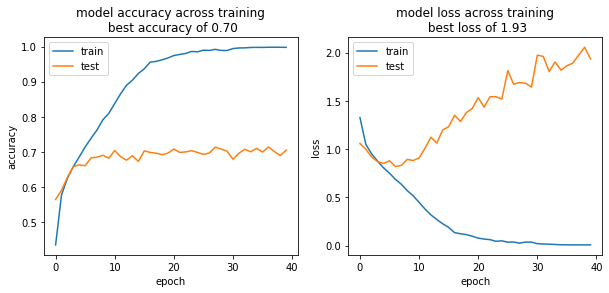

In [ ]:
plot_graphs(vgg_history, vgg_performance);